In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)


Using device: cuda


In [89]:
#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
layer_config= [512, 256]
num_classes = 10
num_epochs = 30
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.99
reg=0#0.001
num_training= 49000
num_validation =1000
fine_tune = True # True
pretrained=True #False


In [90]:
#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
data_aug_transforms = [transforms.RandomHorizontalFlip(p=0.5)]#, transforms.RandomGrayscale(p=0.05)]
###############################################################################
# TODO: Add to data_aug_transforms the best performing data augmentation      #
# strategy and hyper-parameters as found out in Q3.a                          #
###############################################################################


data_aug_transforms.append(torchvision.transforms.RandomAffine(degrees=15,translate=(0.1,0.1)))

data_aug_transforms.append(torchvision.transforms.ColorJitter(brightness=(0.7,1.3),contrast=(0.8,1.3)))


norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     ]) #Need to preserve the normalization values of the pre-trained model
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform
                                          )


Files already downloaded and verified


In [91]:
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)



In [92]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class VggModel(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(VggModel, self).__init__()
        #################################################################################
        # TODO: Build the classification network described in Q4 using the              #
        # models.vgg11_bn network from torchvision model zoo as the feature extraction  #
        # layers and two linear layers on top for classification. You can load the      #
        # pretrained ImageNet weights based on the pretrained flag. You can enable and  #
        # disable training the feature extraction layers based on the fine_tune flag.   #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        model=torchvision.models.vgg11(pretrained=pretrained,progress=True).cuda()
        
        
        if fine_tune==False:
            set_parameter_requires_grad(model,feature_extracting=True)
            
        dense_layer1=[nn.Flatten(),nn.Linear(layer_config[0],layer_config[1]),nn.BatchNorm1d(layer_config[1]),nn.ReLU(inplace=True)]
        
        classification_layer=[nn.Linear(layer_config[1],n_class)]
        
        self.new_model=nn.Sequential(*(list(model.children())[0],*dense_layer1,*classification_layer))
        
        

        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        
        out= self.new_model(x)
        
        

        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out



In [93]:
# Initialize the model for this run
model= VggModel(num_classes, fine_tune, pretrained)

if (pretrained==False):
    model.apply(weights_init)

# Print the model we just instantiated
print(model)

# sanity check
from torchsummary import summary
summary(model.cuda(),(3,32,32))


VggModel(
  (new_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel_

In [94]:
#################################################################################
# TODO: Only select the required parameters to pass to the optimizer. No need to#
# update parameters which should be held fixed (conv layers).                   #
#################################################################################
print("Params to learn:")
if fine_tune:
    params_to_update = []
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    for name,param in model.named_parameters():
        if param.requires_grad==True:
            params_to_update.append(param)
            print("\t",name)
    
    
    
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



Params to learn:
	 new_model.0.0.weight
	 new_model.0.0.bias
	 new_model.0.3.weight
	 new_model.0.3.bias
	 new_model.0.6.weight
	 new_model.0.6.bias
	 new_model.0.8.weight
	 new_model.0.8.bias
	 new_model.0.11.weight
	 new_model.0.11.bias
	 new_model.0.13.weight
	 new_model.0.13.bias
	 new_model.0.16.weight
	 new_model.0.16.bias
	 new_model.0.18.weight
	 new_model.0.18.bias
	 new_model.2.weight
	 new_model.2.bias
	 new_model.3.weight
	 new_model.3.bias
	 new_model.5.weight
	 new_model.5.bias


Epoch [1/30], Step [100/245], Loss: 0.9037
Epoch [1/30], Step [200/245], Loss: 0.6542
Validataion accuracy is: 69.1 %
Epoch [2/30], Step [100/245], Loss: 0.6960
Epoch [2/30], Step [200/245], Loss: 0.7745
Validataion accuracy is: 78.7 %
Epoch [3/30], Step [100/245], Loss: 0.5691
Epoch [3/30], Step [200/245], Loss: 0.5258
Validataion accuracy is: 79.6 %
Epoch [4/30], Step [100/245], Loss: 0.4770
Epoch [4/30], Step [200/245], Loss: 0.4484
Validataion accuracy is: 80.1 %
Epoch [5/30], Step [100/245], Loss: 0.4299
Epoch [5/30], Step [200/245], Loss: 0.4630
Validataion accuracy is: 81.7 %
Epoch [6/30], Step [100/245], Loss: 0.4999
Epoch [6/30], Step [200/245], Loss: 0.3454
Validataion accuracy is: 80.3 %
validation accuracy didnt improve at epoch: 6
Epoch [7/30], Step [100/245], Loss: 0.3635
Epoch [7/30], Step [200/245], Loss: 0.5351
Validataion accuracy is: 82.0 %
Epoch [8/30], Step [100/245], Loss: 0.3715
Epoch [8/30], Step [200/245], Loss: 0.3036
Validataion accuracy is: 84.9 %
Epoch [9/3

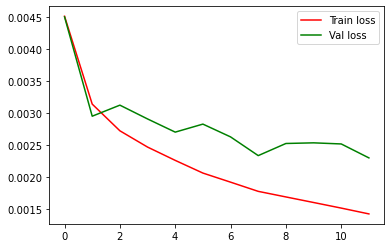

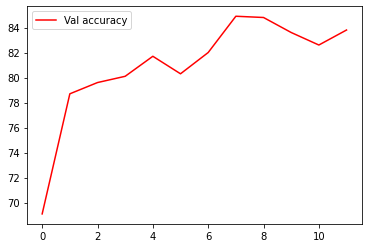

Accuracy of the network on the 1000 test images: 85.1 %


In [95]:
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
best_model = type(model)(num_classes, fine_tune, pretrained) # get a new instance
not_improving_epochs=0
for epoch in range(num_epochs):

    model.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_iter += loss.item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    loss_train.append(loss_iter/(len(train_loader)*batch_size))


    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
            
        loss_val.append(loss_iter/(len(val_loader)*batch_size))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        
        print('Validataion accuracy is: {} %'.format(accuracy))
        #################################################################################
        # TODO: Q2.b Use the early stopping mechanism from previous questions to save   #
        # the model with the best validation accuracy so-far (use best_model).          #
        #################################################################################

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        patience=4
        early_stop=False

        if epoch>patience-1:
            for j in range(patience-1):
                if max(accuracy_val)>list(reversed(accuracy_val))[j]:
                    not_improving_epochs+=1
                    print('validation accuracy didnt improve at epoch: '+str(epoch+1))
                else:
                    not_improving_epochs=0
                    break
                if not_improving_epochs>=patience:
                    early_stop=True
                    print('early stopping clause activated')
                    break
                break
        if early_stop==True:
            print('about to stop')
            torch.save(model.state_dict(), 'model.ckpt')

            break



        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()


plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Val loss')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(accuracy_val, 'r', label='Val accuracy')
plt.legend()
plt.show()



#################################################################################
# TODO: Use the early stopping mechanism from previous question to load the     #
# weights from the best model so far and perform testing with this model.       #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model.load_state_dict(torch.load('model.ckpt'))







# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))



# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')
